## Imports and data


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV again, skipping the second header row
df = pd.read_csv("../data/results_all_cleaned.csv", skiprows=[1])

# Split dataset into groups
df_prolific = df[df["Q0_ProlificID"].notna()]
df_infodienst = df[df["Q0_ProlificID"].isna()]


In [41]:
# Add the second conversation description to the same column
row0 = df.iloc[0]
same_as_header = (row0.values == df.columns.values[:len(row0)]).sum()
if same_as_header >= len(df.columns) * 0.3:
    df = df.iloc[1:].reset_index(drop=True)

meta = df.iloc[:, 0:9]
block_a = df.iloc[:, 9:33]
block_b = df.iloc[:, 33:57]
keep_tail = df.iloc[:, 57:63]

block_b.columns = block_a.columns

df_a = pd.concat([meta.copy(), block_a.copy(), keep_tail.copy()], axis=1)
df_b = pd.concat([meta.copy(), block_b.copy(), keep_tail.copy()], axis=1)
df_with_second_conv = pd.concat([df_a, df_b], axis=0, ignore_index=True)

df_with_second_conv


,Duration (in seconds),Finished,RecordedDate,ResponseId,LocationLatitude,LocationLongitude,UserLanguage,Q_RecaptchaScore,Q0_ProlificID,Q1,...,Q15,Q16,Q17,Q17_1_TEXT,Q35,Q36,Q37,Q38,Q39_1,Q40_1
0,96,True,6/27/25 13:04,R_8yM19IVeLaUfHCF,"48,114","11,5422",DE,"0,8000000119",NaN,No,...,NaN,NaN,NaN,NaN,25,Male,Germany,Civil engineering,1 (Strongly disagree),5 (Strongly agree)
1,676,True,6/27/25 13:14,R_4Iu9zOikNldp2er,"7,3367","80,5179",DE,"0,8999999762",NaN,Yes,...,Yes,Another email program with a better spam filter,"No, but I plan to have one in the future",NaN,26,Male,Germany,Mechanical engineering,1 (Strongly disagree),5 (Strongly agree)
2,2226,True,6/27/25 14:38,R_8SLSBSpVqPTxBVD,"48,1084","11,6102",DE,"0,6000000238",NaN,Yes,...,No,NaN,NaN,NaN,23,Female,Germany,Visual Effects,2,5 (Strongly agree)
3,591,True,6/27/25 14:46,R_8CsDk3qPTiI6qGk,"48,767","9,1827",DE,"0,8000000119",NaN,Yes,...,No,NaN,NaN,NaN,26,Male,Germany,Food science,1 (Strongly disagree),5 (Strongly agree)
4,57,True,6/27/25 16:18,R_9DwDGUdXzMgJuE6,"-6,175","106,8286",EN,"0,3000000119",NaN,I don't know,...,NaN,NaN,NaN,NaN,23,Female,Germany,Media informatics,1 (Strongly disagree),5 (Strongly agree)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,275,True,7/30/25 15:51,R_8IL6OGFrIV8yWkn,"41,1459","-8,6169",EN,"0,8999999762",610d97ed406cb5e7dfc695ae,No,...,NaN,NaN,NaN,NaN,29,Male,Portugal,Warehouse worker,4,5 (Strongly agree)
506,489,True,7/30/25 16:02,R_21MdNknkT1kkHf3,"41,8905","12,5127",EN,"0,400000006",6648adee7d29687acc3a0912,No,...,NaN,NaN,NaN,NaN,55,Male,Italy,Project Manager in IT company,3,5 (Strongly agree)
507,61,True,7/30/25 16:03,R_8m91LHQI4peVgn6,"39,8074","-8,0965",EN,"0,6000000238",6060a91a15fd10f42335b02a,NaN,...,NaN,NaN,NaN,NaN,27,Female,Portugal,Marketing,1 (Strongly disagree),5 (Strongly agree)
508,328,True,7/30/25 16:08,R_1I6N2umDbPZTap5,"28,0932","-15,4574",EN,"0,8999999762",66c4cefb3e98086ecca28a29,No,...,NaN,NaN,NaN,NaN,32,Male,Spain,Game Design,2,5 (Strongly agree)


# Analysis of questions

## Q3: How many people were involved, apart from you?

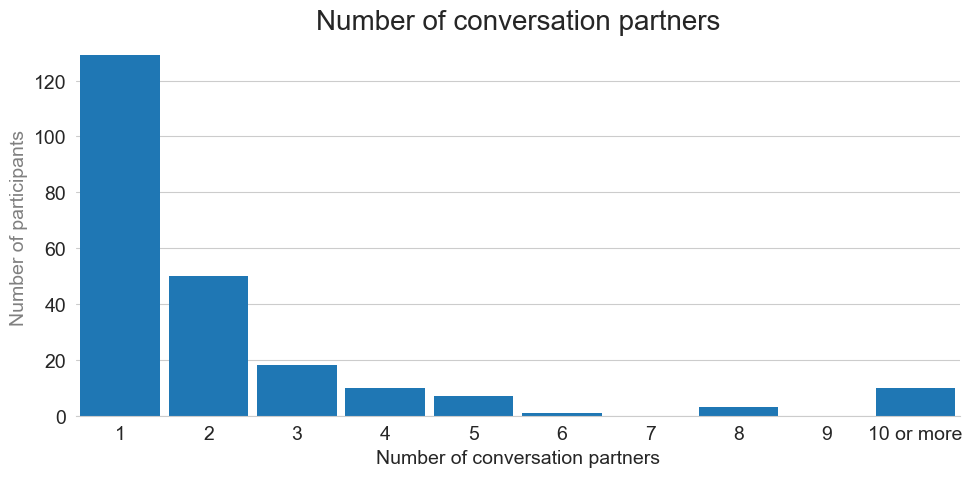

    count  share_%
1     129     57.0
2      50     22.0
3      18      8.0
4+     31     14.0


In [42]:
def preprocess_participants(df_input, column):
    df_input = df_input.copy()

    df_exploded = df_input.dropna().astype(int).explode(column)

    return df_exploded.reset_index()[[column]]

def plot_participants(df_input, column, title):
    plt.figure(figsize=(10, 5))

    # Replace all values >10 with 10 (will represent "10+")
    data = df_input[column].clip(upper=10)

    # Count occurrences for 1–9 and the binned "10+"
    counts = data.value_counts().reindex(range(1, 11), fill_value=0)

    # Plot bars
    bars = plt.bar(counts.index, counts.values, width=0.9, edgecolor="none")
    plt.rcParams.update({'font.size': 14})

    plt.title("Number of conversation partners")
    plt.xlabel("Number of conversation partners")
    plt.ylabel("Number of participants", color="gray")
    plt.grid(axis="x")

    labels = list(range(1, 10)) + ["10 or more"]
    plt.xticks(range(1, 11), labels)

    plt.xlim(0.5, 10.5)

    ax = plt.gca()
    ax.set_title(title, fontsize=20)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()

df_preprocessed = preprocess_participants(df_with_second_conv[["Q3"]], "Q3")

plot_participants(df_preprocessed, "Q3", 'Number of conversation partners')

vals = pd.to_numeric(df_preprocessed["Q3"], errors="coerce")
binned = vals.where(vals <= 4, 4)
counts = binned.value_counts().reindex([1, 2, 3, 4], fill_value=0).sort_index()
shares_pct = (counts / counts.sum() * 100).round()

result = pd.DataFrame(
    {"count": counts.values, "share_%": shares_pct.values},
    index=["1", "2", "3", "4+"]
)

print(result)


## Q5: Who started the conversation?

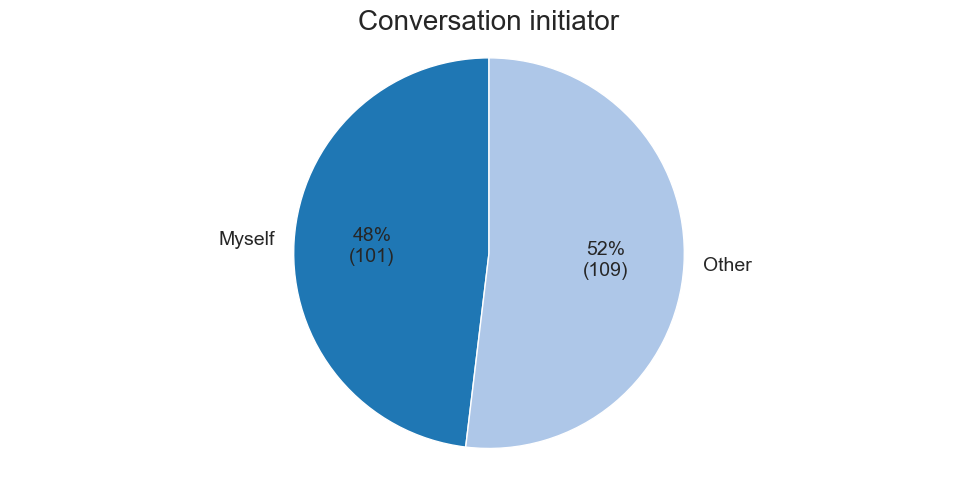

In [43]:
def preprocess_initiator(df_input, column):
    df_input = df_input.copy()

    df_exploded = df_input.dropna(subset=[column]).explode(column)

    return df_exploded.reset_index()[[column]]

def plot_initiator(df_input, column, title):
    counts = df_input[column].value_counts()

    counts = counts.sort_values(ascending=True)

    colors = plt.cm.tab20.colors

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.rcParams.update({'font.size': 14})

    wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.f%%', startangle=90, colors=colors)

    # Add absolute values to the pie chart
    for autotext, label in zip(autotexts, counts.index):
        percentage_text = autotext.get_text()
        count = counts[label]
        autotext.set_text(f'{percentage_text}\n({count})')

    ax.set_title(title, fontsize=20)
    ax.axis('equal')

    plt.tight_layout()
    plt.show()

df_preprocessed = preprocess_initiator(df_with_second_conv[["Q5"]], "Q5")

plot_initiator(df_preprocessed, "Q5", 'Conversation initiator')


## Q6: Did anybody else join the conversation after you started?

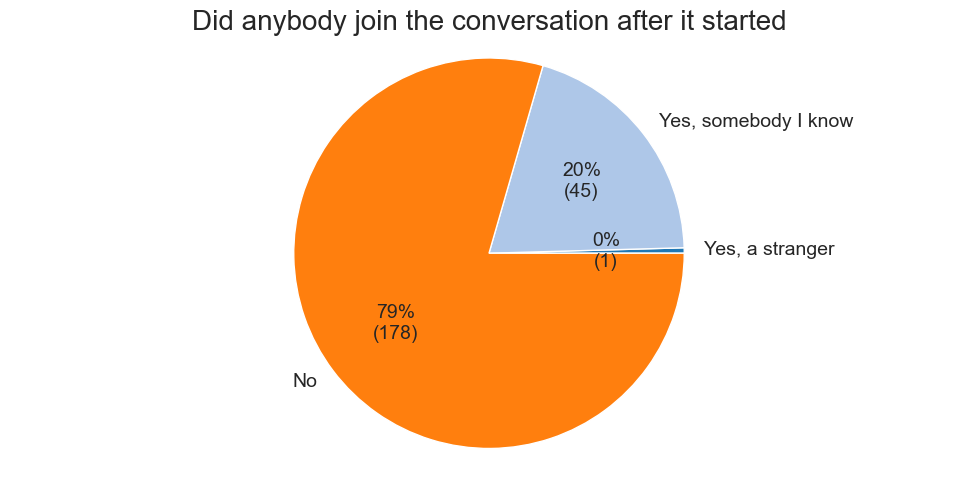

In [44]:
def preprocess_initiator(df_input, column):
    df_input = df_input.copy()

    df_exploded = df_input.dropna(subset=[column]).explode(column)

    return df_exploded.reset_index()[[column]]

def plot_initiator(df_input, column, title):
    counts = df_input[column].value_counts()

    counts = counts.sort_values(ascending=True)

    colors = plt.cm.tab20.colors

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.rcParams.update({'font.size': 14})

    wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.f%%', colors=colors)

    # Add absolute values to the pie chart
    for autotext, label in zip(autotexts, counts.index):
        percentage_text = autotext.get_text()
        count = counts[label]
        autotext.set_text(f'{percentage_text}\n({count})')

    ax.set_title(title, fontsize=20)
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

df_preprocessed = preprocess_initiator(df_with_second_conv[["Q6"]], "Q6")

plot_initiator(df_preprocessed, "Q6", 'Did anybody join the conversation after it started')


## Q7: Where did this conversation happen?

Q7
Other                    8.771930
Public space            14.912281
Workplace/University    34.210526
At home                 42.105263
Name: count, dtype: float64


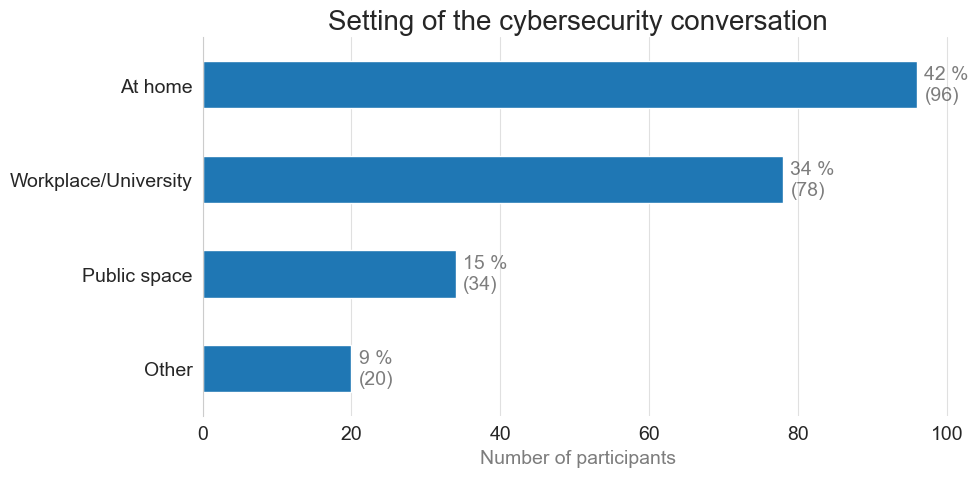

In [45]:
def preprocess_setting(df_input, column, second_column):
    df_input = df_input.copy()

    df_input[column] = df_input.apply(
        lambda row: row[second_column]
        if str(row[column]).strip() == "Other (please specify)" and pd.notna(row[second_column])
        else row[column],
        axis=1
    )

    df_exploded = df_input.dropna(subset=[column]).assign(
        conv=df_input[column].dropna().str.strip()
    ).explode(column)

    df_exploded[column] = df_exploded[column].replace(
        {"Public space (e.g., café, train)": "Public space"}
    )

    df_exploded = df_exploded[df_exploded[column] != "Other (please specify)"]

    to_other = {"party", "online", "Online call", "phone call", "chat", "doctor's office", "car", "Online call"}
    df_exploded[column] = df_exploded[column].apply(
        lambda x: "Other" if x.strip().lower() in to_other else x
    )

    return df_exploded.reset_index()[[column]]

def plot_setting(df_exploded, column, title):
    counts_final = df_exploded[column].value_counts()
    counts_final = counts_final.sort_values(ascending=True)
    total_responses = counts_final.sum()
    q7_percentages = (counts_final / total_responses) * 100
    print(q7_percentages)


    fig, ax = plt.subplots(figsize=(10, 5))

    bars = counts_final.plot(kind="barh", ax=ax)
    plt.rcParams.update({'font.size': 14})
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Number of participants", alpha=0.6)
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    plt.grid(axis='x', alpha=0.6)
    ax.grid(axis='y', visible=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for i in range(len(counts_final)):
        count = counts_final.iloc[i]
        percentage = q7_percentages.iloc[i]
        ax.text(count + 1, i, f'{percentage:.0f} %\n({count})', ha='left', va='center', alpha=0.6)

    plt.tight_layout()
    plt.show()

df_preprocessed = preprocess_setting(df_with_second_conv[["Q7", "Q7_4_TEXT"]], "Q7", "Q7_4_TEXT")

plot_setting(df_preprocessed, "Q7", 'Setting of the cybersecurity conversation')


## Q8: What led to the topic of cybersecurity coming up?

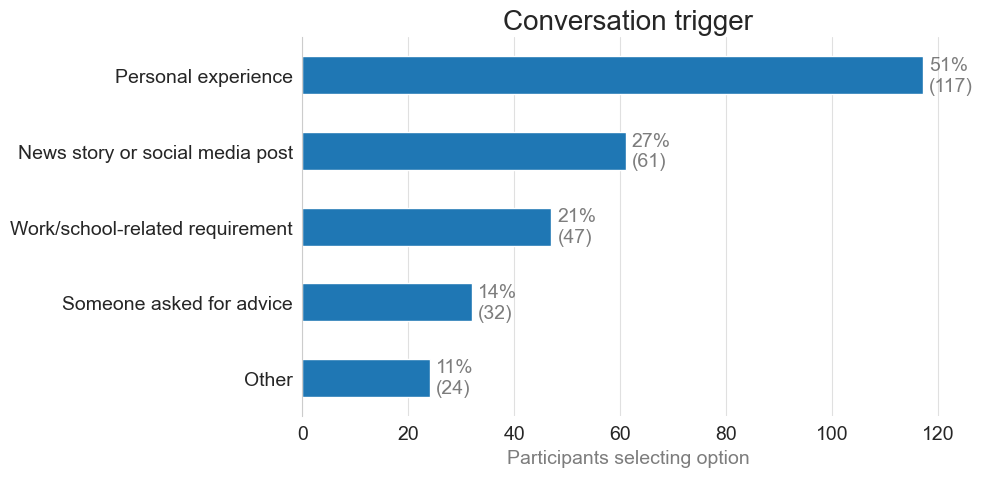

In [46]:
def preprocess_trigger(df_input, column):
    df_input = df_input.copy()

    df_input = df_input.loc[df_input[column].notna()].copy()

    df_input[column] = (
        df_input[column].astype(str)
        .str.split(",")
    )

    n_respondents = df_input.shape[0]

    df_exploded = df_input.explode(column)
    df_exploded[column] = df_exploded[column].str.strip()

    df_exploded[column] = df_exploded[column].replace({
        "Other (please specify)": "Other",
        "Personal experience (e.g. cybersecurity incident)": "Personal experience"
    })

    return df_exploded.reset_index()[[column]], n_respondents

def plot_trigger(df_input, n_respondents, column, title):
    counts = df_input[column].value_counts().sort_values(ascending=True)

    percent = (counts / n_respondents) * 100

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    counts.plot(kind="barh", ax=ax)

    plt.rcParams.update({'font.size': 14})

    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Participants selecting option", alpha=0.6)
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    ax.grid(axis='x', alpha=0.6)
    ax.grid(axis='y', visible=False)
    for spine in ['top','right','bottom']:
        ax.spines[spine].set_visible(False)

    for i, (cat, count) in enumerate(counts.items()):
        pct = percent.loc[cat]
        ax.text(count + max(counts)*0.01, i, f"{pct:.0f}%\n({count})",
                ha="left", va="center", alpha=0.6)

    plt.tight_layout()
    plt.show()

df_preprocessed, n_respondents = preprocess_trigger(df_with_second_conv[["Q8"]], "Q8")

plot_trigger(df_preprocessed, n_respondents, "Q8", "Conversation trigger")


## Q9: What specific cybersecurity issue(s) did you discuss?

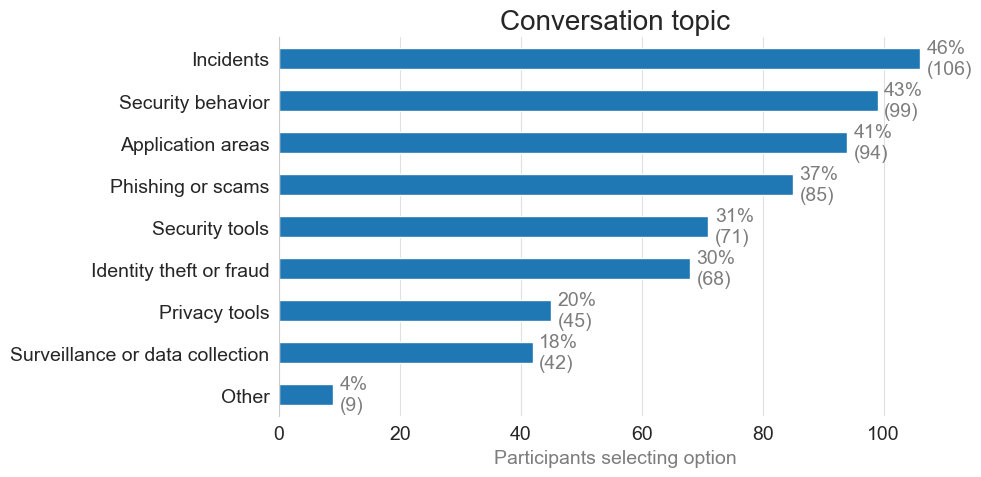

In [47]:
def preprocess_topics(df_input, column):
    df_input = df_input.copy()

    df_input = df_input.loc[df_input[column].notna()].copy()

    df_input[column] = (
        df_input[column].astype(str)
        .str.split(",")
    )

    n_respondents = df_input.shape[0]

    df_exploded = df_input.explode(column)
    df_exploded[column] = df_exploded[column].str.strip()

    df_exploded[column] = df_exploded[column].replace({
        "Other (please specify)": "Other"
    })

    return df_exploded.reset_index()[[column]], n_respondents

def plot_topics(df_input, n_respondents, column, title):
    counts = df_input[column].value_counts().sort_values(ascending=True)

    percent = (counts / n_respondents) * 100

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    counts.plot(kind="barh", ax=ax)

    plt.rcParams.update({'font.size': 14})

    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Participants selecting option", alpha=0.6)
    ax.set_ylabel("")
    ax.tick_params(axis='y', rotation=0)
    ax.grid(axis='x', alpha=0.6)
    ax.grid(axis='y', visible=False)
    for spine in ['top','right','bottom']:
        ax.spines[spine].set_visible(False)

    for i, (cat, count) in enumerate(counts.items()):
        pct = percent.loc[cat]
        ax.text(count + max(counts)*0.01, i, f"{pct:.0f}%\n({count})",
                ha="left", va="center", alpha=0.6)

    plt.tight_layout()
    plt.show()

df_preprocessed, n_respondents = preprocess_topics(df_with_second_conv[["Q9"]], "Q9")

plot_topics(df_preprocessed, n_respondents, "Q9", "Conversation topic")


## Q10: Confidence

Q10_1
1    0.030702
2    0.083333
3    0.223684
4    0.403509
5    0.258772
Name: count, dtype: float64


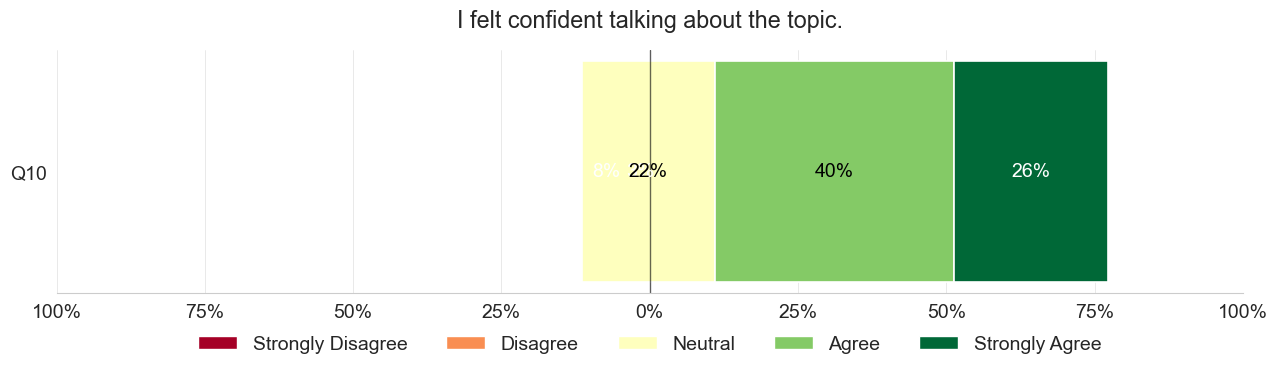

In [48]:
q10 = df_with_second_conv["Q10_1"].dropna()

mapping = {
    "1 (Strongly disagree)": "1",
    "2": "2",
    "3": "3",
    "4": "4",
    "5 (Strongly agree)": "5",
    "1": "1",
    "5": "5"
}
q10 = q10.replace(mapping)

order = ["1","2","3","4","5"]
labels_long = ["Strongly Disagree","Disagree","Neutral","Agree","Strongly Agree"]

counts = q10.value_counts().reindex(order, fill_value=0)
props = (counts / counts.sum()).reindex(order)

print(props)

segments = np.array([ -props["1"], -props["2"], props["3"], props["4"], props["5"] ], dtype=float)

fig, ax = plt.subplots(figsize=(13, 4))

cmap = plt.colormaps.get_cmap("RdYlGn")
colors = [cmap(i/4) for i in range(5)]

left = 0.0
for seg, col in zip(segments, colors):
    ax.barh(
        ["Q10"],
        [seg],
        left=left,
        color=col,
        edgecolor="white",
        linewidth=1.2,
        height=0.5
    )
    left += seg

# Center line and light grid like the example
ax.axvline(0, color="black", linewidth=1, alpha=0.6)
ax.grid(axis="x", linewidth=0.5, alpha=0.6)
ax.grid(axis="y", visible=False)

# Remove spines for a clean look
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Title and x label
ax.set_title("I felt confident talking about the topic.", pad=16)

# Format x-axis as percentages from -100% to +100%
ax.set_xlim(-1, 1)
ax.set_xticks(np.linspace(-1, 1, 9))
ax.set_xticklabels([f"{int(abs(x)*100)}%" for x in np.linspace(-1,1,9)])

# y-axis label
ax.set_ylabel("")
ax.set_yticks(["Q10"])

centers = []
left = 0.0
for seg in segments:
    centers.append(left + seg/2)
    left += seg

def text_color(rgba):
    r,g,b,a = rgba
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "black" if lum > 0.65 else "white"

# Add labels only if segment is wide enough (>= 3%)
for ctr, seg, lab, col, prop in zip(centers, segments, labels_long, colors, props):
    width = abs(seg)
    if width >= 0.03:
        ax.text(
            ctr,
            0,
            f"{int(round(width*100))}%",
            va="center",
            ha="center",
            color=text_color(col),
        )

from matplotlib.patches import Patch
handles = [Patch(facecolor=c, edgecolor="white", label=l)
           for c, l in zip(colors, labels_long)]

ax.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),  # bottom center
    ncol=5,
    frameon=False
)

plt.tight_layout()
plt.show()


## Q11 & Q13: Emotions

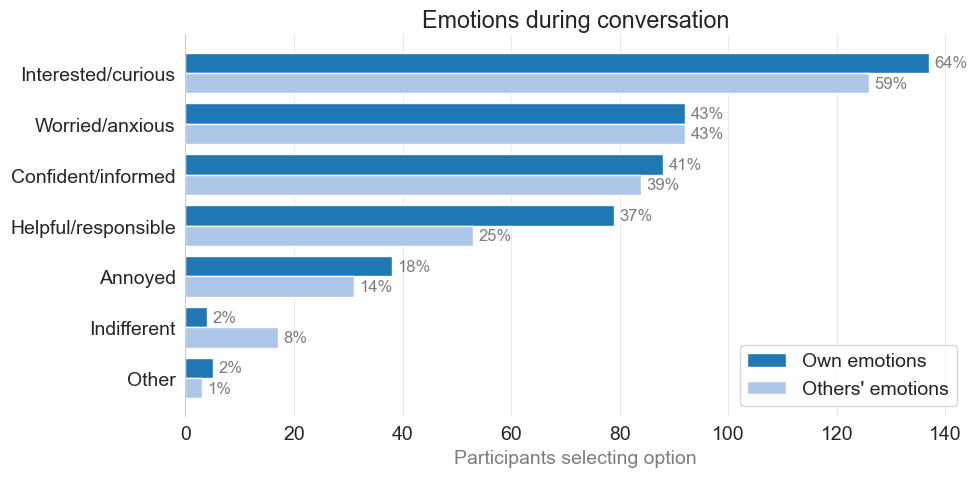

In [49]:
def explode_emotions(dataframe, col):
    ans = dataframe.loc[dataframe[col].notna(), [col]].copy()
    ans[col] = ans[col].astype(str).str.split(",")
    exploded = ans.explode(col)
    exploded[col] = exploded[col].astype(str).str.strip()
    exploded = exploded[exploded[col] != ""]
    exploded[col] = exploded[col].replace({
        "Other (please describe)": "Other",
    })

    exploded[col] = exploded[col].str.replace(r"\s*;\s*", ", ", regex=True)
    return exploded

q11_exp = explode_emotions(df_with_second_conv, "Q11")
q13_exp = explode_emotions(df_with_second_conv, "Q13")

q11_den = df["Q11"].notna().sum()
q13_den = df["Q13"].notna().sum()

q11_counts = q11_exp["Q11"].value_counts()
q13_counts = q13_exp["Q13"].value_counts()

all_cats = sorted(set(q11_counts.index).union(set(q13_counts.index)))

q11_counts = q11_counts.reindex(all_cats, fill_value=0)
q13_counts = q13_counts.reindex(all_cats, fill_value=0)

order = pd.Series(q11_counts.values + q13_counts.values, index=all_cats).sort_values(ascending=True).index
q11_counts = q11_counts.reindex(order)
q13_counts = q13_counts.reindex(order)


q11_pct = (q11_counts / q11_den * 100).round(1)
q13_pct = (q13_counts / q13_den * 100).round(1)


cats = q11_counts.index.tolist()

x = np.arange(len(cats))
width = 0.4

colors = plt.cm.tab20.colors
color_own = colors[0]
color_other = colors[1]

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.barh(x + width/2, q11_counts.values, height=width, label="Own emotions", color=color_own)
bars2 = ax.barh(x - width/2, q13_counts.values, height=width, label="Others' emotions", color=color_other)

ax.set_yticks(x)
ax.set_yticklabels(cats)
ax.set_xlabel("Participants selecting option", alpha=0.6)
ax.set_title("Emotions during conversation")
ax.legend()

ax.grid(axis='x', alpha=0.4)
ax.grid(axis='y', visible=False)
for spine in ['top','right','bottom']:
        ax.spines[spine].set_visible(False)


for bars, pct_series, count_series, offset in [
    (bars1, q11_pct, q11_counts, -0.2),
    (bars2, q13_pct, q13_counts, 0.2)
]:
    for i, bar in enumerate(bars):
        count = count_series.iloc[i]
        pct = pct_series.iloc[i]
        if count > 0:
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f"{pct:.0f}%", va="center", ha="left", fontsize=12, alpha=0.6)

plt.tight_layout()
plt.show()


## Q17: Did you have, or do you plan to have, a follow-up conversation?

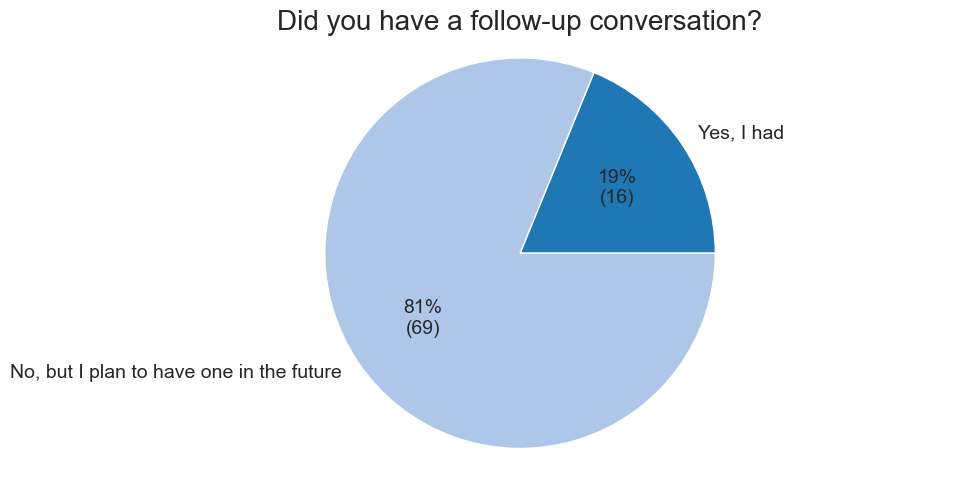

In [50]:
def preprocess_initiator(df_input, column):
    df_input = df_input.copy()

    df_exploded = df_input.dropna(subset=[column]).explode(column)

    df_exploded[column] = df_exploded[column].replace({
        "Yes, I had (How many?)": "Yes, I had",
        "Yes, I already had a follow-up conversation (How many?)": "Yes, I had"
    })

    return df_exploded.reset_index()[[column]]

def plot_initiator(df_input, column, title):
    counts = df_input[column].value_counts()

    counts = counts.sort_values(ascending=True)

    colors = plt.cm.tab20.colors

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.rcParams.update({'font.size': 14})

    wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.f%%', colors=colors)

    for autotext, label in zip(autotexts, counts.index):
        percentage_text = autotext.get_text()
        count = counts[label]
        autotext.set_text(f'{percentage_text}\n({count})')

    ax.set_title(title, fontsize=20)
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

df_preprocessed = preprocess_initiator(df_with_second_conv[["Q17"]], "Q17")

plot_initiator(df_preprocessed, "Q17", 'Did you have a follow-up conversation?')
